# ANSWER KEY for HW04: Fitting normal distributions for each calendar month and fitting GEV to annual maxima

## Load the Central Park data into this python session

:::{admonition} Explanation of data downloading logic (if you're interested)
:class: dropdown
To make these Jupyter notebooks work when launched to Google Colab---which you can do by clicking the "rocket" icon in the top right from the rendered version of this page on the web---we need some logic that downloads the data.

While we're at it, we use the file's "hash" to check that it has not been altered or corrupted from its original version.  We do this whether or not you've downloaded the file, since it's possible to (accidentally) modify the netCDF file on disk after you downloaded it.

In the rendered HTML version of the site, this cell is hidden, since otherwise it's a bit distracting.  But you can click on it to reveal its content.

If you're in a Google Colab session, you don't need to modify anything in that cell; just run it.  Otherwise, modify the `LOCAL_DATA_DIR` variable defined in the next python cell to point to where the dataset lives on your machine---or where you want it to be downloaded to if you don't have it already.
:::

In [1]:
!pip install pooch

# The above command installs the needed `pooch` 3rd-party package if it's not already installed.


import hashlib  # for verifying that the Central Park file is not corrupted
import pathlib  # for constructing paths to the dataset's location on disk
import sys  # for checking if this is a Google Colab session or not
import pooch  # for downloading the dataset from the web, if needed


# Replace "../data" as needed to point to the correct directory for you.
# This can be an *absolute path* or a *relative path*.  One dot, `.`, means
# "this directory", while two dots, `..`, means "go up one directory."
LOCAL_DATA_DIR = "../data"  # If you're in Colab: just ignore this.

# The URL where the dataset can be downloaded from.
DATA_URL = (
    "https://spencerahill.github.io/25f-stat-methods-course/_downloads/"
    "91803b82950d49961a65355c075439b3/central-park-station-data_1869-01-01_2023-09-30.nc"
)

# This HASH_HEX stores a "hash" which we use to verify that the data you end up
# with has not been altered or corrupted compared to the one at the above URL.
HASH_HEX = "85237a4bae1202030a36f330764fd5bd0c2c4fa484b3ae34a05db49fe7721eee"


def create_data_path(
    colab_dir="/content/data", 
    local_dir=LOCAL_DATA_DIR,
    filename="central-park-station-data_1869-01-01_2023-09-30.nc",
):
    """Set the path for the data, whether on colab or a local Jupyter session."""
    is_this_a_colab = "google.colab" in sys.modules
    if is_this_a_colab:
        data_dir = colab_dir 
    else: 
        data_dir = local_dir

    DATA_DIR = pathlib.Path(data_dir)
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    return DATA_DIR / filename


def sha256sum(path: pathlib.Path) -> str:
    """Get the hash of the file at the specified path."""
    return hashlib.sha256(path.read_bytes()).hexdigest()


DATA_PATH = create_data_path()
# Determine if we'll need to download the data, which we'll do if either (a) 
# the data can't be found, or (b) it appears corrupted/modified from the
# "master" file at the above URL.
need_fetch = (not DATA_PATH.exists()) or (sha256sum(DATA_PATH) != HASH_HEX)

# Download the data if needed.
if need_fetch:
    fetched_data = pooch.retrieve(
        url=DATA_URL, 
        known_hash=f"sha256:{HASH_HEX}",
        path=DATA_PATH.parents[0], 
        fname=DATA_PATH.name,
    )
    print(f"\nDownloaded and verified: {fetched_data}")
else:
    print(f"\nVerified existing file at {DATA_PATH}")

Looking in links: https://pypi.python.org/pypi, https://testpypi.python.org/pypi

Verified existing file at ../data/central-park-station-data_1869-01-01_2023-09-30.nc


In [2]:
import xarray as xr

# `DATA_PATH` variable was created by the hidden cell just above. 
# Un-hide that cell if you want to see the details.
ds_cp = xr.open_dataset(DATA_PATH)
ds_cp

<xarray.Dataset> Size: 5MB
Dimensions:        (time: 56520)
Coordinates:
  * time           (time) datetime64[ns] 452kB 1869-01-01 ... 2023-09-30
Data variables:
    temp_max       (time) int64 452kB ...
    temp_min       (time) int64 452kB ...
    temp_avg       (time) float64 452kB ...
    temp_anom      (time) float64 452kB ...
    heat_deg_days  (time) int64 452kB ...
    cool_deg_days  (time) int64 452kB ...
    precip         (time) float64 452kB ...
    snow_fall      (time) float64 452kB ...
    snow_depth     (time) int64 452kB ...

## Your specific tasks

### Normal distribution fits throughout the year

For each of the 12 calendar months, January through December, do the following:

- [ ] fit a normal distribution to the *daily maximum temperature* from the Central Park weather station dataset, for all days in that month across all years
- [ ] Plot the histogram (with `density=True`) for that month, and overlay the curve of the fitted PDF

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import scipy

In [4]:
# First drop the errant 0.0 values
tmax_valid = ds_cp["temp_max"].where(ds_cp["temp_max"] != 0, drop=True)

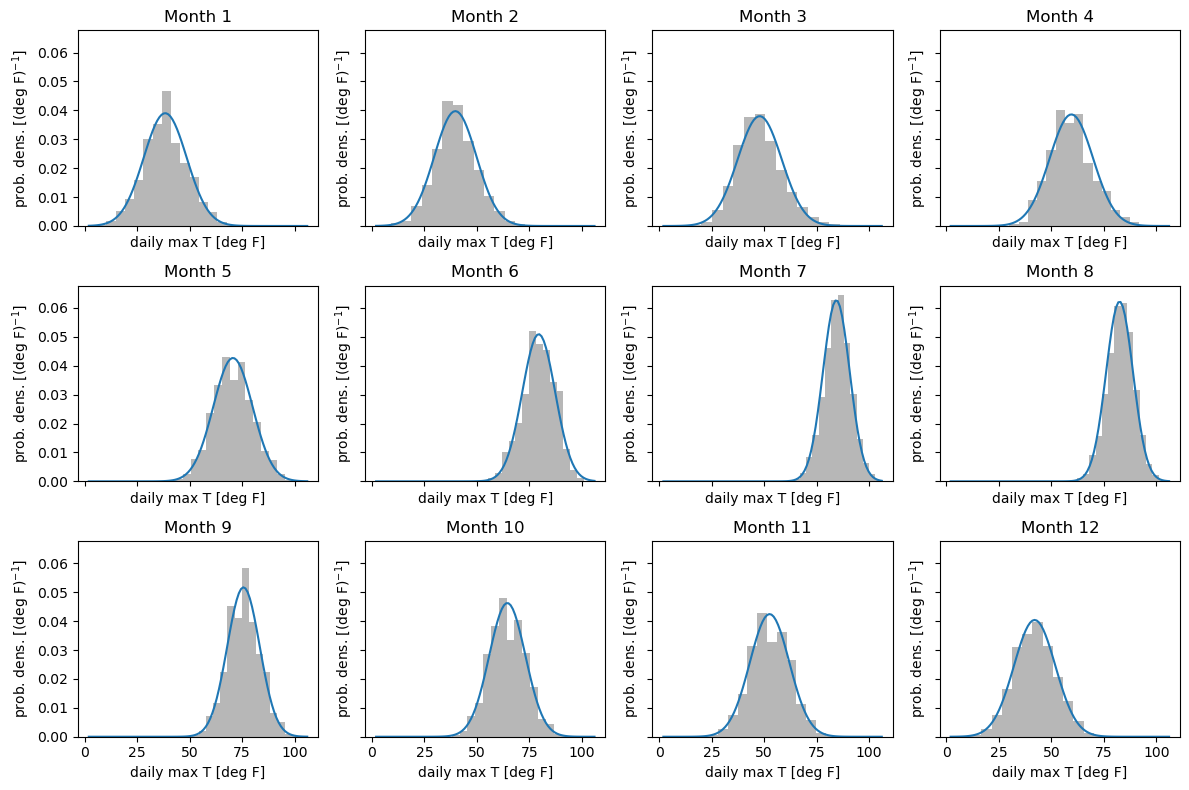

In [5]:
months = range(1, 13)
xvals_for_norm_fit = np.linspace(tmax_valid.min().values, tmax_valid.max().values, 100)


fig, axes = plt.subplots(3, 4, figsize=(12, 8), sharex=True, sharey=True)

for ax, m in zip(axes.ravel(), months):
    subset = tmax_valid.sel(time=tmax_valid["time.month"] == m)
    ax.hist(subset.values, density=True, bins=15, alpha=0.4, color='0.3')
    fit_mean, fit_stdev = scipy.stats.norm.fit(subset)
    ax.plot(xvals_for_norm_fit, 
            scipy.stats.norm(loc=fit_mean, scale=fit_stdev).pdf(xvals_for_norm_fit))
    ax.set_title(f'Month {m}')
    ax.set_xlabel("daily max T [deg F]")
    ax.set_ylabel(r"prob. dens. [(deg F)$^{-1}$]")
    
plt.tight_layout()
plt.show()

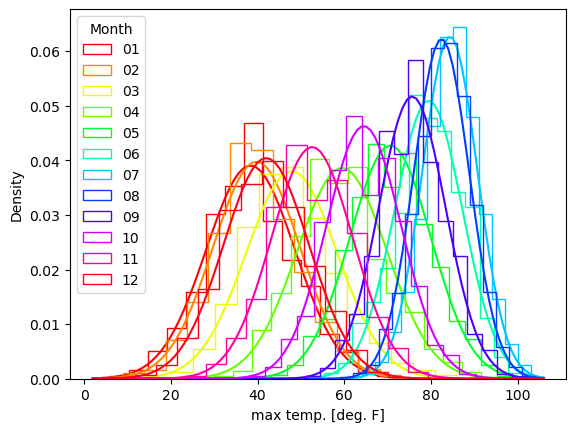

In [6]:
import matplotlib.pyplot as plt

colors = plt.get_cmap('hsv', 12)
for m in range(1, 13):
    subset = tmax_valid.sel(time=tmax_valid['time.month'] == m)
    plt.hist(subset.values, bins=15, density=True, histtype='step', 
             color=colors(m-1), label=f'{m:02d}')
    fit_mean, fit_stdev = scipy.stats.norm.fit(subset)
    plt.plot(xvals_for_norm_fit, 
            scipy.stats.norm(loc=fit_mean, scale=fit_stdev).pdf(xvals_for_norm_fit),
            color=colors(m-1))

plt.legend(title='Month')
plt.xlabel("max temp. [deg. F]")
plt.ylabel('Density')
plt.show()


In [7]:
tmax_grouped = ds_cp["temp_max"].groupby("time.month")

After you've done that, make two more plots.  One is for the sample mean, one is for the sample standard deviation.  For the sample mean:

- [ ] Plot the sample mean for each calendar month as a function of month.  So the x-axis is month, numbered 1-12, and the y-axis is the mean.
- [ ] On the same axes, plot the mean **from the fitted normal distribution**.

For the sample standard deviation, do the exact same: 

- [ ] Plot the sample standard deviation for each calendar month as a function of month.  So the x-axis is month, numbered 1-12, and the y-axis is the sample standard deviation.
- [ ] On the same axes, plot the standard deviation **from the fitten normal distribution**.

Put these panels right next to each other in one single `pyplot.Figure` object: use `plt.subplots` for this.

In [8]:
def norm_fit_as_arr(*args):
    """Wrapper around scipy.stats.norm.fit that returns an xr.DataArray

    Needed for xarray's groupby/map logic to work.
    """
    mean, stdev = scipy.stats.norm.fit(*args)
    return xr.DataArray([mean, stdev], dims=["param"], coords={"param": ["mean", "stdev"]})
    
fitted_mean_stdev = tmax_grouped.map(norm_fit_as_arr)

Text(0.5, 1.0, '')

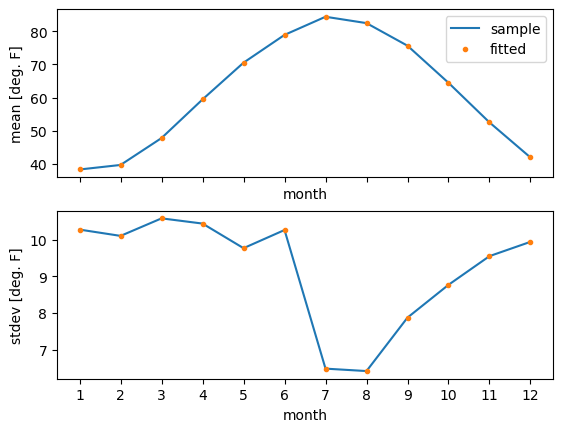

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

tmax_grouped.mean().plot(ax=ax1, label="sample")
fitted_mean_stdev.sel(param="mean").plot(ax=ax1, label="fitted", marker=".", linestyle="none")
ax1.set_ylabel("mean [deg. F]")
ax1.set_title("")
ax1.legend()

tmax_grouped.std(ddof=1).plot(ax=ax2, label="sample")
fitted_mean_stdev.sel(param="stdev").plot(ax=ax2, label="fitted", marker=".", linestyle="none")
ax2.set_xticks(range(1, 13))
ax2.set_ylabel("stdev [deg. F]")
ax2.set_title("")

Last, once you've done this, plot the histogram for *all days*.  You'll see that, as we saw in one of the lectures, this has a double peak structure.  Based on your histograms and fitted normal distributions for each of the 12 calendar months, explain in a few sentences how this double-peaked structure for the whole year comes about.

Note that you don't need to appeal to physical processes or arguments...make your arguments solely as regards how the sample means and standard deviations vary across the twelve months.  (Hint: consider, what would the annual-mean distribution look like if the standard deviation was constant across months, and the mean shifted smoothly up and down?  Would that get you two peaks or not?)

Text(0, 0.5, 'prob. density [1 / (deg F)]')

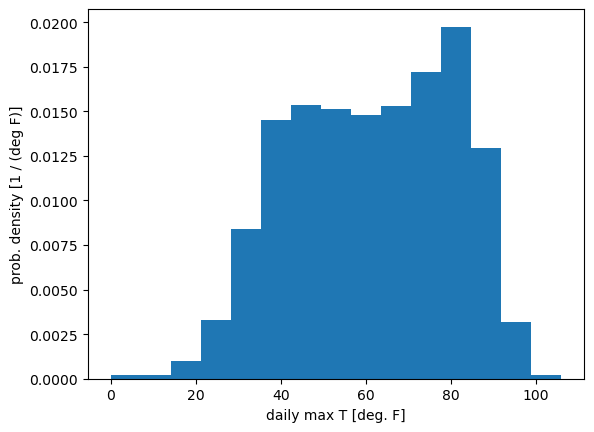

In [10]:
plt.hist(ds_cp["temp_max"], density=True, bins=15)
plt.xlabel("daily max T [deg. F]")
plt.ylabel("prob. density [1 / (deg F)]")

**ANSWER**: The distributions for all months are very well approximated by a normal, meaning that we can think solely in terms of the variations across the 12 months in the mean and standard deviation.

The standard deviation is smallest in July, August, which is when the mean is highest.  This means that when temperatures are warm, the distribution is packed together more tightly.  That in turn creates the global highest peak in the all-year PDF around 80F.

For the (very slight) secondary maximum at much colder max temperatures, around 45F or so, we see that those stem from the coldest months.  Their standard deviations are much larger---temperature variance in the mid-latitudes tends to be greater in winter than summer---so we can't appeal to the same arguments.

Instead, the answer lies in the fact that there are simply more of them stacked on top of each other: December, January, and February all look very similar.  So you end up with more probability here, resulting in the second maximum.

In between these two maxima which correspond to summer and winter, the spring and fall months neither have very small standard deviations nor bunch up on top of each other, resulting in the (slight) local minimum here.

### Block maxima and other metrics of extremes for diurnal temperature range

Compute the **diurnal temperature range** by taking the daily maximum temperature minus the daily minimum temperature.

In [11]:
temp_diurnal = (ds_cp["temp_max"] - ds_cp["temp_min"])
# Drop days with either min or max T zero, due to suspicion that these are invalid.
tdiurn_valid = temp_diurnal.where(tmax_valid).where(
    ds_cp["temp_min"] != 0, drop=True)

Then, compute the following metrics of extreme values for this new variable:

- block max (single largest value in each calendar year)
- an **exceedance count**: the number of days exceeding the *climatological* 95th percentile, meaning the 95th percentile computed using *all days across all years*
- the exceedance count again but using the 99.9th percentile
- The 99th percentile value *computed for that individual year*

Compare these different metrics of extremes.  Describe in a few sentences the extent to which they behave similarly vs. differ from one another.  This is an important part of extreme value analysis: making sure that your results don't sensitively depend on the specific definition of "extreme" or specific threshold.

In [12]:
def exceed_count(arr, thresh):
    """Count of instances exceeding the specified quantile."""
    return arr.where(arr > thresh).count()

ann_max = tdiurn_valid.groupby("time.year").max()
exceed_95 = tdiurn_valid.groupby("time.year").map(
    exceed_count, args=(tdiurn_valid.quantile(0.95),))
exceed_99p9 = tdiurn_valid.groupby("time.year").map(
    exceed_count, args=(tdiurn_valid.quantile(0.999),))
ann_99 = tdiurn_valid.groupby("time.year").quantile(0.99)

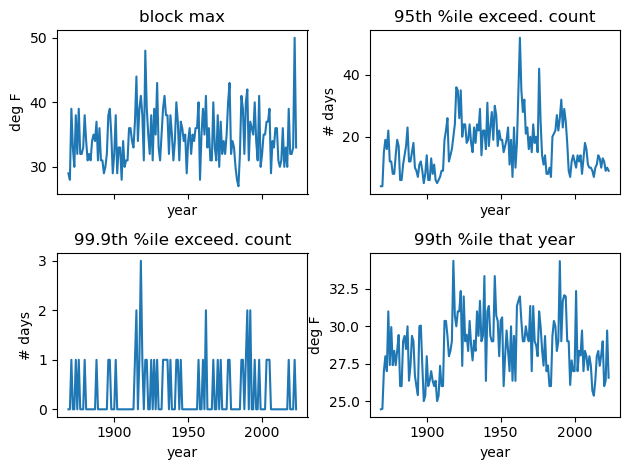

In [13]:
fig, axarr = plt.subplots(2, 2, sharex=True)
ann_max.plot(ax=axarr.flatten()[0])
exceed_95.plot(ax=axarr.flatten()[1])
exceed_99p9.plot(ax=axarr.flatten()[2])
ann_99.plot(ax=axarr.flatten()[3])

ax_titles = ("block max", "95th %ile exceed. count", 
             "99.9th %ile exceed. count", "99th %ile that year")
ylabels = "deg F", "# days", "# days", "deg F"
for ax, title, ylabel in zip(axarr.flatten(), ax_titles, ylabels):
    ax.set_title(title)
    ax.set_ylabel(ylabel)

plt.tight_layout()

We see that the timeseries of these different metrics of extremes look a lot different.  By eye, the two that look the most similar are the block max and the yearly 99th percentile value (top left and lower right).  But even for these, the correlation is only around 0.5:

In [14]:
xr.corr(ann_99, ann_max)

<xarray.DataArray ()> Size: 8B
array(0.51070174)
Coordinates:
    quantile  float64 8B 0.99

This doesn't mean that we can't say anything meaningful about the extreme events in this sample!  It just means we need to be honest with ourselves and others about the fact that different metrics give different results.

Also, if we "narrow the range", we find results that are more robust.  For example, compare the exceedance count timeseries going from the 90th through 99th percentiles:

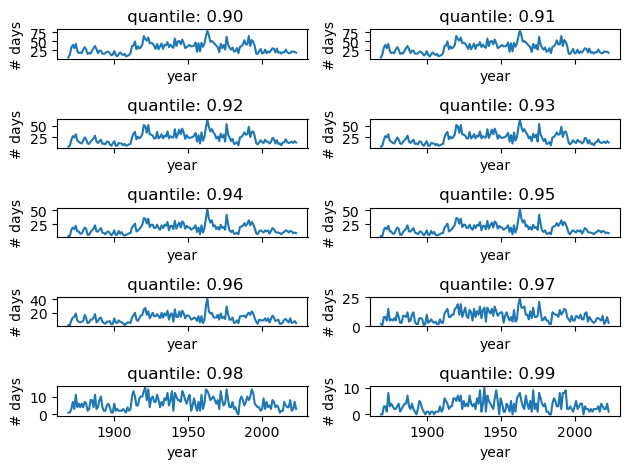

In [15]:
fig, axarr = plt.subplots(5, 2, sharex=True)

quantiles = np.arange(0.9, 0.991, 0.01)
for ax, quantile in zip(axarr.flatten(), quantiles):
    ex_count = tdiurn_valid.groupby("time.year").map(
        exceed_count, args=(tdiurn_valid.quantile(quantile),))
    ex_count.plot(ax=ax)
    ax.set_title(f" quantile: {quantile:0.2f}")
    ax.set_ylabel("# days")

plt.tight_layout()

For percentiles from the 90th through the 96th, the curves look similar in their year-to-year fluctuations, even though their mean values steadily decrease as you go to larger percentiles.

For example, the correlation between the 90th and 96th percentiles is 0.89:

In [16]:
xr.corr(
    tdiurn_valid.groupby("time.year").map(
        exceed_count, args=(tdiurn_valid.quantile(0.90),)),
    tdiurn_valid.groupby("time.year").map(
        exceed_count, args=(tdiurn_valid.quantile(0.96),)),
)

<xarray.DataArray ()> Size: 8B
array(0.8887822)

So we can say that for exceedance counts, the results are not strongly sensitive to the percentile chosen, within the range of the 90th-96th.  Above that, the behaviors starts to differ more appreciably.  (And we don't know about below that, because we didn't check!)

### GEV fit for the block maxima

Use `scipy.stats.genextreme` to fit a GEV to the block max computed just above for the diurnal temperature range.  Plot the normalized histogram of this block max and overlay the fitted GEV curve.  Describe your impressions of the goodness of fit based on visual inspection of this plot.

In [17]:
shape, loc, scale = scipy.stats.genextreme.fit(ann_max)
fitted_gev = scipy.stats.genextreme(c=shape, loc=loc, scale=scale)

Text(0.5, 1.0, 'Annual block maximum diurnal temperature range')

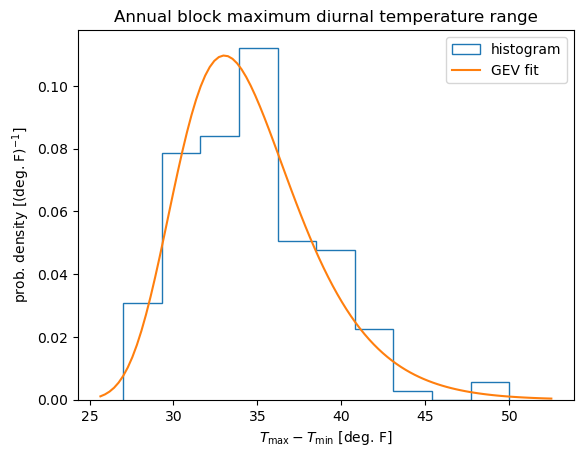

In [18]:
xvals_for_ann_max_fit = np.linspace(ann_max.min().values*0.95, ann_max.max().values*1.05, 100)
plt.hist(ann_max, bins=10, density=True, histtype='step', label="histogram")
plt.plot(xvals_for_ann_max_fit, fitted_gev.pdf(xvals_for_ann_max_fit), label="GEV fit")
plt.legend()
plt.xlabel(r"$T_\mathrm{max}-T_\mathrm{min}$ [deg. F]")
plt.ylabel(r"prob. density [(deg. F)$^{-1}$]")
plt.title("Annual block maximum diurnal temperature range")

Nice!  The GEV is a pretty good fit.  It captures the overall peak and the positive skewness.